<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#define-base-class-for-policy" data-toc-modified-id="define-base-class-for-policy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>define base class for policy</a></span></li><li><span><a href="#define-base-class-for-Q-Learning" data-toc-modified-id="define-base-class-for-Q-Learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>define base class for Q Learning</a></span></li><li><span><a href="#Class-for-Experience-Replay-Buffer" data-toc-modified-id="Class-for-Experience-Replay-Buffer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Class for Experience Replay Buffer</a></span></li><li><span><a href="#DQN-Policy" data-toc-modified-id="DQN-Policy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DQN Policy</a></span></li><li><span><a href="#Define-Experiment-Function" data-toc-modified-id="Define-Experiment-Function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define Experiment Function</a></span></li><li><span><a href="#Train-and-run-policy-for-Taxi-V2" data-toc-modified-id="Train-and-run-policy-for-Taxi-V2-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train and run policy for Taxi V2</a></span></li><li><span><a href="#Train-and-run-Policy-for-FrozenLake" data-toc-modified-id="Train-and-run-Policy-for-FrozenLake-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train and run Policy for FrozenLake</a></span></li><li><span><a href="#Train-and-run-Policy-for-CartPole" data-toc-modified-id="Train-and-run-Policy-for-CartPole-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Train and run Policy for CartPole</a></span></li><li><span><a href="#Further-Work" data-toc-modified-id="Further-Work-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Further Work</a></span></li></ul></div>

In [1]:
import gym
print('OpenAI Gym:',gym.__version__)
import numpy as np
print('NumPy:',np.__version__)
import matplotlib.pyplot as plt

OpenAI Gym: 0.10.9
NumPy: 1.15.4


## define base class for policy

In [2]:
class policy():
    def __init__(self):
        self.debug = False
        self.learn_mode = False

## define base class for Q Learning

In [3]:
class policy_q(policy):
    def __init__(self,
                 nS,
                 nA,
                 discount_rate=0.9,
                 learning_rate=0.8,
                 explore_rate_max=0.9,
                 explore_rate_min=0.01,
                 explore_rate_decay=0.005):
        super().__init__()
        self.dr = discount_rate
        self.lr = learning_rate
        self.er = explore_rate_max
        self.er_max = explore_rate_max
        self.er_min = explore_rate_min
        self.er_decay = explore_rate_decay

        if not isinstance(nS, np.ndarray):
            self.nS = np.array(nS)
        else:
            self.nS = nS
        if not isinstance(nA, np.ndarray):
            self.nA = np.array(nA)
        else:
            self.nA = nA

    def max_er(self, er_max=None):
        if er_max is not None:
            self.er_max = er_max
        self.er = self.er_max
        return self.er

    def zero_er(self):
        self.er = 0.0
        return self.er

    def decay_er(self, step):
        self.er = self.er_min + (
            self.er_max - self.er_min) * np.exp(
            -self.er_decay * step)
        if self.debug:
            print('New er after decay:', self.er)
        return self.er

## Class for Experience Replay Buffer

In [4]:
import random
random.seed(123)

class Memory():
    def __init__(self, capacity):
        self.cap = capacity
        self.mem = []
        self.ptr = 0

    def append(self, item):
        if len(self.mem) < self.cap:
            self.mem.append(None)
        self.mem[self.ptr] = item
        self.ptr = (self.ptr + 1) % self.cap

    def sample(self, size):
        return random.sample(self.mem, size)

    def __len__(self):
        return len(self.mem)

## DQN Policy

In [5]:
import torch

class PolicyDQN(policy_q):
    def __init__(self,
                 nS,
                 nA,
                 discount_rate=0.9,
                 learning_rate=0.8,
                 explore_rate_max=0.9,
                 explore_rate_min=0.01,
                 explore_rate_decay=0.005):
        super().__init__(nS, nA, discount_rate, learning_rate,
                         explore_rate_max, explore_rate_min,
                         explore_rate_decay)
        self.__name__ = 'DQN'
        self.device = torch.device('cuda' if torch.cuda.
                                   is_available() else 'cpu')
        # TODO make batch size passable
        self.batch_size = 512
        self.tnet_update_threshold = 10 
        
        memory_capacity = self.batch_size * 100

        # create the empty list to contain game memory
        #        from collections import deque
        #        self.memory = deque(maxlen=memory_len)
        self.memory = Memory(memory_capacity)

        # create a q-nn of shape (S X A)
        # representing S X A -> R
        self.policy_net = self.build_nn()
        self.optimizer = torch.optim.RMSprop(self.policy_net.parameters())
        
        self.target_net = self.build_nn()
        self.update_target_net()
        self.target_net.eval()

        self.loss_fn = torch.nn.MSELoss()

    def build_nn(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(self.nS, 512), torch.nn.ReLU(),
            torch.nn.Linear(512, 512), torch.nn.ReLU(),
            torch.nn.Linear(512, self.nA)).to(self.device)
        return model

    def get_action(self, s):
        # Exploration - Select a random action
        if self.learn_mode and np.random.random() < self.er:
            a = random.randrange(self.nA)
        # Exploitation - Select the action with the highest q
        else:
            with torch.no_grad():
                s = torch.tensor([s],
                                   dtype=torch.float,
                                   device=self.device)
                a = self.policy_net(s).argmax().item()
        return a

    def update(self, s, a, r, s_, done):
        # add the s,a,r,s_ to memory
        if done:
            s_ = None
        self.memory.append([list(s) if isinstance(s,np.ndarray) else [s], 
                            [a], [r], 
                            list(s_) if isinstance(s_,np.ndarray) else [s_]])
        if len(self.memory) >= self.batch_size:
            sample = self.memory.sample(self.batch_size)
            ss, aa, rr, ss_ = zip(*sample)

            ss = torch.tensor(ss, dtype=torch.float, device=self.device)
            aa = torch.tensor(aa, dtype=torch.long, device=self.device)
            rr = torch.tensor(rr, dtype=torch.float, device=self.device)
                    
            nt_mask = torch.tensor(
                tuple(map(lambda st: st[0] is not None, 
                          ss_)
                     ), 
                dtype=torch.uint8)
            nt_ss_ = torch.tensor([st for st in ss_ if \
                                   st[0] is not None],
                                  dtype=torch.float,
                                  device=self.device)

            v_s_ = torch.zeros(
                len(ss_), 1, device=self.device)
            v_s_[nt_mask] = self.target_net(
                nt_ss_).detach().max(1)[0].unsqueeze(1)
            e_q_sa = rr + (self.dr * v_s_)
            
            q_sa = self.policy_net(ss).gather(1, aa)

            loss = self.loss_fn(q_sa, e_q_sa)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

## Define Experiment Function

In [6]:
# t_max = 0 : run until done
# t_max > 0 : run each episode for t_max steps at max
# g_max = 0 : run until done
# g_max > 0 : run each episode for g_max return at max
from tqdm import trange
import sys
def experiment(env, policy, n_episodes=1, g_max=0, t_max=0, r_max=0, learn_mode = False, debug=False):

    returns = np.zeros(shape=(n_episodes))
    policy.learn_mode = learn_mode

    for i in trange(n_episodes, file=sys.stdout, dynamic_ncols=True ):
        #1. observe initial state
        s = env.reset()

        # initialize the counters
        done = False
        g = 0
        t = 0
        while not done:

            #2. select an action, and observe the next state
            a = policy.get_action(s)
            s_, r, done, _ = env.step(a)
                
            if debug:
                print('SARS=',s,a,r,s_, done)
                #env.render()
            
            #3. update the policy internals
            #if policy.learn_mode:
            policy.update(s,a,r,s_, done)

            # set next state as current state
            s = s_

            # update the counters
            g += r
            t += 1
            
            if r_max > 0 and r >= r_max:
                break
            if g_max > 0 and g >= g_max:
                break
            if t_max > 0 and t >= t_max:
                break

        returns[i] = g
        if debug and (i + 1) % 100 == 0:
            print(
                'E#={}, G= Mean:{:0.2f},Min:{:0.2f},Max:{:0.2f}'
                .format(i+1, 
                        returns[:i].mean(),
                        returns[:i].min(), 
                        returns[:i].max()))
        if policy.learn_mode:
            # decay the epsilon i.e. explore rate
            policy.decay_er(i)
        if (i+1) % policy.tnet_update_threshold == 0:
            policy.update_target_net()
    if n_episodes > 1:
        print(
            'Policy:{}, E\'s={}, G= Mean:{:0.2f},Min:{:0.2f},Max:{:0.2f}'.
            format(policy.__name__, n_episodes, np.mean(returns),
                   np.min(returns), np.max(returns)))
        plt.plot(returns)
        plt.title('Environment {} with algo {}'.format(env.spec.id,policy.__name__))
        plt.xlabel('Episode #')
        plt.ylabel('Cumulative Rewards (G)')
        plt.show()
    else:
        print('Policy:{}, G= {}'.format(policy.__name__, returns[0]))
    return returns

## Train and run policy for Taxi V2

/opt/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


training policies
100%|██████████| 10000/10000 [1:44:31<00:00,  1.63it/s]
Policy:DQN, E's=10000, G= Mean:-215.88,Min:-1658.00,Max:-26.00


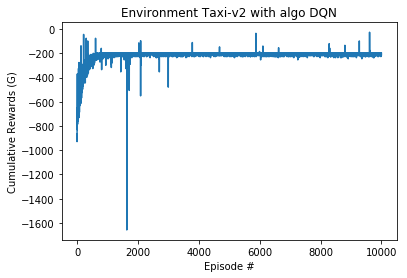

using trained policies
100%|██████████| 10/10 [00:06<00:00,  1.62it/s]
Policy:DQN, E's=10, G= Mean:-200.00,Min:-200.00,Max:-200.00


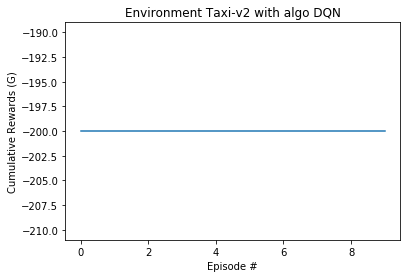

In [7]:
env=gym.make('Taxi-v2')

# remove the seeds to get random plays everytime
np.random.seed(123)
env.seed(123)

policy_dqn = PolicyDQN(1,env.action_space.n)

print('training policies')
n_episodes = 10000
_=experiment(env,policy_dqn, n_episodes, learn_mode=True)

print('using trained policies')
n_episodes=10
_=experiment(env,policy_dqn,n_episodes)

env.close()
del env
del policy_dqn

## Train and run Policy for FrozenLake

training policies
  1%|          | 69/10000 [00:00<00:16, 601.04it/s]

/opt/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


100%|██████████| 10000/10000 [04:24<00:00, 37.74it/s]
Policy:DQN, E's=10000, G= Mean:0.01,Min:0.00,Max:1.00


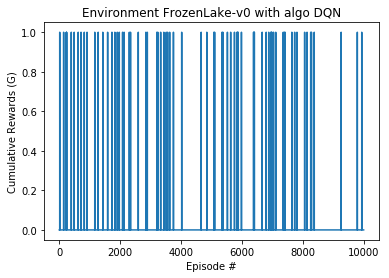

using trained policies
100%|██████████| 10/10 [00:00<00:00, 37.29it/s]
Policy:DQN, E's=10, G= Mean:0.00,Min:0.00,Max:0.00


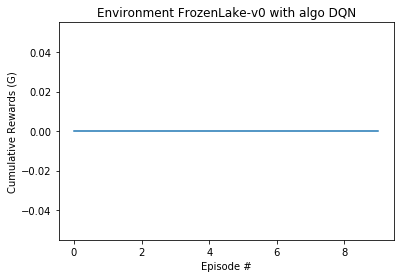

In [8]:
env=gym.make('FrozenLake-v0')

# remove the seeds to get random plays everytime
np.random.seed(123)
env.seed(123)

policy_dqn = PolicyDQN(1,env.action_space.n)

print('training policies')
n_episodes = 10000
_=experiment(env,policy_dqn, n_episodes, learn_mode=True)

print('using trained policies')
n_episodes = 10
_=experiment(env,policy_dqn,n_episodes)

env.close()
del env
del policy_dqn

## Train and run Policy for CartPole

training policies
100%|██████████| 10000/10000 [52:26<00:00,  2.74it/s] 
Policy:DQN, E's=10000, G= Mean:96.08,Min:8.00,Max:200.00


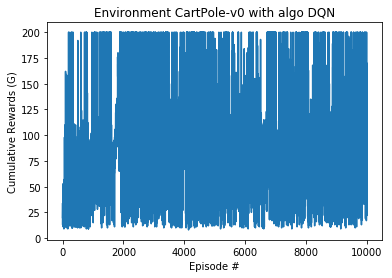

using trained policies
100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
Policy:DQN, E's=10, G= Mean:119.00,Min:88.00,Max:165.00


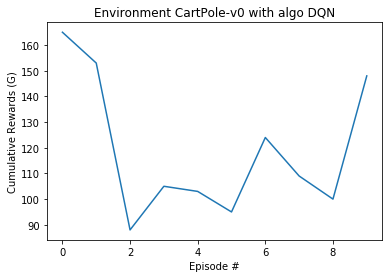

In [9]:
env=gym.make('CartPole-v0')

# remove the seeds to get random plays everytime
np.random.seed(123)
env.seed(123)

policy_dqn = PolicyDQN(4,env.action_space.n)

print('training policies')
n_episodes = 10000
_=experiment(env,policy_dqn, n_episodes, learn_mode=True)

print('using trained policies')
n_episodes = 10
_=experiment(env,policy_dqn,n_episodes)

env.close()
del env
del policy_dqn

## Further Work

In [10]:
# Run the code on PacMan or Pong games after modifying 
#    to handle image data and use CNN Network.
